In [34]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


### Implement Identity Block
Identity block is the standard block used in Resnet, and corresponds to the case where the input activation has the same dimension as the output activation

In [4]:
def identity_block(X, f, filters, training = True, initializer = random_uniform):
    """Implementation identity block:
    Arguments:
    X -- Input tensor shape (batch_size, n_H_prev, n_W_prev, n_C_prev)
    f -- Integer, specifying the shape of the middle Conv's window for the main path
    filters -- python list of integers, defining the number of filters in the conv layers of the main path
    trainning -- True: Behave in train mode
                 False: Behave in inference mode
    initializer -- Set up the initial weights of layer. Equal to random uniform
    
    =================================================================================

    Returns: 
    X -- output of identity block, tensor of shape is (batch_size, n_H, n_W, n_C)
    """

    X_shortcut = X

    F1, F2, F3 = filters

    # first Block of identity
    #========================================================================================================================
    X = Conv2D(F1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)#||
    # padding = valid meaning no padding, F1 is number of filters, kernel_size is shape of conv's window                  #||
    X = BatchNormalization(axis = 3)(X, training = training)                                                              #||
    # first batchnormalize is normalizing the 'channels' axis                                                             #||
    X = Activation('relu')(X)                                                                                             #||
    #========================================================================================================================

    # Second Block of identity
    #========================================================================================================================
    X = Conv2D(F2, kernel_size = (f, f), strides = (1, 1), padding = "same", kernel_initializer = initializer(seed=0))(X) #||
    # padding = same results in padding with zeros evenly to the left/right/up/down of the input                          #||
    X = BatchNormalization(axis = 3)(X, training = training)                                                              #||
    X = Activation('relu')(X)                                                                                             #||
    #========================================================================================================================

    # Third Block of identity
    #========================================================================================================================
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)#||
    X = BatchNormalization(axis = 3)(X, training = training)                                                              #||
    #========================================================================================================================

    # Final Step:
    #================================================================================================================
    X = Add()([X, X_shortcut])                                                                                    #||
    X = Activation('relu')(X)                                                                                     #||
    #================================================================================================================
    return X

2023-04-21 13:14:50.375136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-21 13:14:50.376298: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


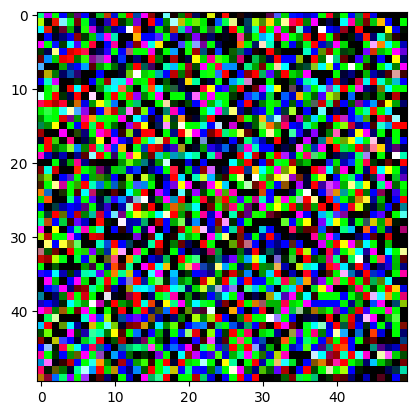

In [5]:
np.random.seed(1)
tf.random.set_seed(2)
X1 = np.random.randn(1, 50, 50, 3) * -1
X2 = np.random.randn(1, 50, 50, 3) * 1
X3 = np.random.randn(1, 50, 50, 3) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)
A = identity_block(X, 3, [8, 16, 3])
plt.imshow(A[0])
plt.show()

## Convolutional Block


The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

In [6]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    X = Conv2D(F1, kernel_size = 1, strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    
    X_shortcut = Conv2D(F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 50, 50, 3)
(3, 25, 25, 6)


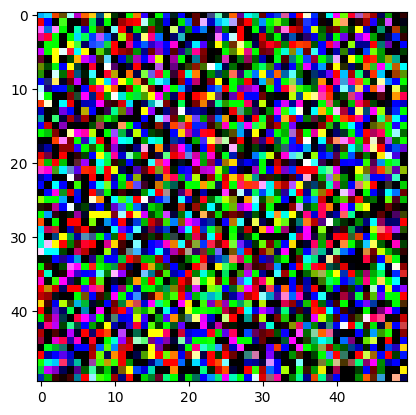

In [7]:
X = np.random.randn(3, 50, 50, 3)
A = convolutional_block(X, f=2, filters=[2, 4, 6])
plt.imshow(X[0, :, :, :])
print(X.shape)
print(A.shape)

In [23]:
img = cv2.imread('cat.jpg')
cat = cv2.imread('cat1.jpg')
# cv2.imshow(img)
print(img.shape)

(2048, 1184, 3)


(500, 500, 3)


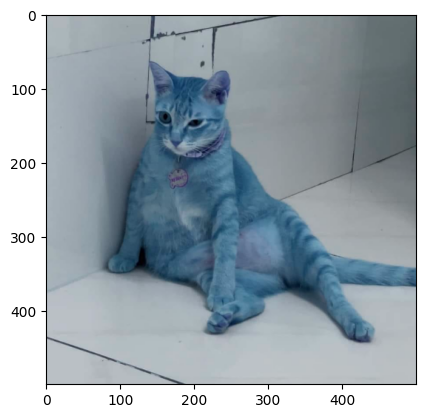

In [24]:
resized_img_1 = cv2.resize(img, (500, 500))
resized_img_2 = cv2.resize(cat, (500, 500))
# print(resized_img.shape)
plt.imshow(resized_img_2)

In [25]:
expand_img_1 = np.expand_dims(resized_img_1, axis = 0)
expand_img_2 = np.expand_dims(resized_img_2, axis = 0)
X = np.concatenate((expand_img_1, expand_img_2), axis = 0).astype(np.float32)
A = convolutional_block(X, f = 2, filters = [4, 8 , 16])
print(A.shape)

(2, 250, 250, 16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


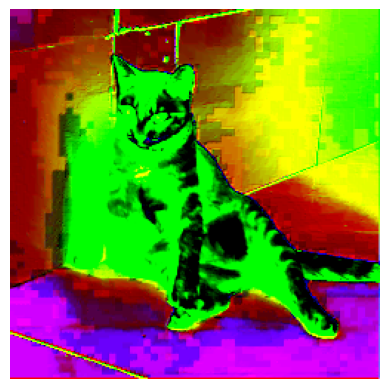

In [33]:
plt.imshow(A[1, :, :, 3:6])
plt.axis('off')
plt.show()

In [36]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architechture of the popular resnet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1:
    X = Conv2D(64, kernel_size = (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed = 42))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)

    #Stage 2:
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, f = 3, filters = [64, 64, 256])
    X = identity_block(X, f = 3, filters = [64, 64, 256])

    #Stage 3:
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])

    # Stage 4:
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    #Stage 5:
    X = convolutional_block(X , f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    X = identity_block(X, f = 3, filters = [512, 512, 2048])

    X = AveragePooling2D((2, 2))(X)

    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', kernel_initializer = glorot_uniform(seed = 0))(X)

    model = Model(inputs = X_input, outputs = X)
    return model


    

In [37]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])